<a href="https://colab.research.google.com/github/jloser/ticket_simulation/blob/main/ticket_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install simpy

In [ ]:
# some constants definitions
RANDOM_SEED = 42

# ticket category dict with duration as values
TICKET_CATEGORIES = {
    "ACCOUNT": 25,
    "INSTALL_BASE": 15,
    "QA_CHECK": 10,
}

TICKET_PRIORITIES = {
    "STD": False,
    "HIGH": True,
}

TICKET_BACKLOG = 200
TICKET_PREFIX = "RSS_"

# Level, number of advisors, tickets per day
ADVISORS = {
    "EXP": {
        "NUM": 3,
    },
    "STD": {
        "NUM": 100,
    },
    "ROOKIE": {
        "NUM": 5,
    },
}

TICKET_FREQUENCY = 0.96
TICKET_FREQUENCY_SIGMA = TICKET_FREQUENCY / 2
TICKET_DURATION_SIGMA = 5

# Working standards
WEEK_DAYS = 7
WORK_DAYS = 5
WORK_HOURS = 8
EFFICIENCY_FACTOR = 0.85
# if there are questions back, the OpCo needs two working days
OPCO_DURATION = 2 * WORK_HOURS * 60
WORK_MINUTES = WORK_DAYS * WORK_HOURS * 60 * EFFICIENCY_FACTOR
# Careful, calculating with work hours
WEEKEND_MINUTES = (WEEK_DAYS-WORK_DAYS) * WORK_HOURS * 60

WEEKS = 52

# only working hours
SIM_TIME = WEEKS * WEEK_DAYS * 24 * 60

# for testing, shorter times
SIM_TIME = 52416

MONITORING_TIME = WORK_HOURS * 30

CSV_FILE = 'log.csv'
CSV_HEADER = ['time', 'created', 'resolved', 'backlog']

In [ ]:
from os import sep
import simpy
import random
from time import sleep
import numpy as np
import pandas as pd
import csv

class Tracker:
    def __init__(self, env):
        self.env = env
        try:
            with open(CSV_FILE, mode='w', newline='') as logfile:
                writer = csv.writer(logfile, delimiter=';')
                writer.writerow(CSV_HEADER)
        except OSError:
            print('Can\'t open log file!')
            

    def track_status(self, stats):
        # append the ticket data to the dataframe
        self.write_row(stats)

    def write_row(self, row):
        with open(CSV_FILE, mode='a', newline='') as logfile:
            writer = csv.writer(logfile, delimiter=';')
            writer.writerow(row.values())

class Ticket:
    """create a ticket with a random category and random priority"""

    def __init__(self):
        # randomly create a ticket
        accessor = random.randint(0, len(TICKET_CATEGORIES) - 1)
        i = 0
        for key, value in TICKET_CATEGORIES.items():
            if i == accessor:
                self.category = key
                self.duration = value
                break
            i += 1
        accessor = random.randint(0, len(TICKET_PRIORITIES) - 1)
        i = 0
        for key, value in TICKET_PRIORITIES.items():
            if i == accessor:
                self.prio = key
                break
            i += 1

    def set_id(self, id):
        self.id = id

    def get_id(self):
        return self.id

    def get_duration(self):
        return self.duration

# Class definition for department
class ServiceNowSystem:
    """store system which allows to receive and give out tickets
    initial_backlog = backlog at start of simulation
    backlog = current backlog
    """

    def __init__(self, env, init_backlog, tracker):
        self.env = env
        self.tracker = tracker
        self.store = simpy.Store(env, capacity=simpy.core.Infinity)
        # fill the store with the initial backlog
        self.id_num = 0
        self.backlog = 0
        self.clear_stats()
        while self.id_num < init_backlog:
            ticket = Ticket()
            self.put_ticket(ticket)

    def get_backlog(self):
        return len(self.store.items)
    
    def get_statistics(self):
        stats = {
            'time': self.env.now,
            'created': self.created,
            'resolved': self.resolved,
            'backlog': self.get_backlog(),
        }
        self.clear_stats()
        return stats

    def clear_stats(self):
        self.created = 0
        self.resolved = 0

    def put_ticket(self, ticket):
        # generate an ID before storing it
        ticket.set_id(self.generate_id())
        self.store.put(ticket)
        self.id_num += 1
        self.created += 1

    def generate_id(self):
        return TICKET_PREFIX + str(self.id_num)

    def get_ticket(self):
        ticket = self.store.get()
        self.resolved += 1
        return ticket

class Ricoh_resource:
    def __init__(self, env, clock):
        self.env = env
        self.clock = clock
        self.weekend = False
        self.env.process(self.weekend_controller())

    def weekend_controller(self):
        while True:
            yield self.clock.start_weekend
            self.weekend = True
            yield self.clock.end_weekend
            self.weekend = False

class Opco(Ricoh_resource):
    """Class that randomly tickets based on frequency
    tickets have priority set, and are stored in the ServiceNowSystem
    tickets can have different categories, depending on category
    it takes more or less time.
    Inherits from Ricoh_resource class the weekend methods
    """

    def __init__(self, env, snow, clock):
        # calling the parents __init__
        super().__init__(env, clock)
        self.tickets_created = 0
        self.env = env
        self.snow = snow
        env.process(self.start_ticket_creation())

    def start_ticket_creation(self):
        while True:
            if not self.weekend:
                self.create_ticket()
                # wait time is a random intervall
                wait_time = abs(
                    random.normalvariate(TICKET_FREQUENCY, TICKET_FREQUENCY_SIGMA)
                )
                yield self.env.timeout(wait_time)
            else:
                yield self.clock.end_weekend

    def create_ticket(self):
        # create a fresh ticket object
        ticket = Ticket()
        self.snow.put_ticket(ticket)
        self.tickets_created += 1

    def get_num_tickets_created(self):
        return self.tickets_created

class Clock:
    """ clock that triggers the advisors to go to weekend every 
    5 * 24 * 60 minutes
    """
    def __init__(self, env):
        self.env = env
        """ create the weekend event """
        self.start_weekend = env.event()
        self.end_weekend = env.event()
        self.env.process(self.start_work())
    
    def start_work(self):
        while True:
            """ wait for the weekend """
            yield self.env.timeout(WORK_MINUTES)
            """ trigger the weekend event"""
            # print(f"Happy weekend @ {env.now}!!")            
            self.start_weekend.succeed()
            # setup new event            
            self.start_weekend = self.env.event()
            yield self.env.timeout(WEEKEND_MINUTES)           
            # print(f"Back to work!! # {env.now}")
            self.end_weekend.succeed()
            # setup new event
            self.end_weekend = self.env.event()

class Advisor(Ricoh_resource):
    """ resource that gets ticket from store analyses the category,
    duration, and priority, based on that and the Advisor level,
    the ticket duration is calculated
    Inherits from Ricoh_resource
    """

    def __init__(self, env, snow, level, id, clock):
        super().__init__(env, clock)
        self.env = env
        self.snow = snow
        self.level = level
        self.tickets_processed = 0
        self.id = id
        # start processing next ticket
        self.env.process(self.process_tickets())

    def process_tickets(self):
        while True:
            # take a ticket out
            if not self.weekend:
                ticket = yield self.snow.get_ticket()
                duration = abs(self.calculate_ticket_duration(ticket))
                yield self.env.timeout(duration)
                self.tickets_processed += 1
            else:
                yield self.clock.end_weekend

    def calculate_ticket_duration(self, ticket):
        """calculate duration based on level of advisor and ticket
        duration + a random standard deviation
        """
        if self.level == "EXP":
            std_deviation = -3
        elif self.level == "STD":
            std_deviation = 0
        else:
            std_deviation = +5
        return std_deviation +\
            random.normalvariate(ticket.get_duration(), TICKET_DURATION_SIGMA)
    
    def get_id(self):
        return self.id

    def get_level(self):
        return self.level

    def get_processed(self):
        return self.tickets_processed


def create_advisors(env, snow, clock):
    advisors = []
    for level in ADVISORS:
        i = 0
        for a in range(ADVISORS[level]["NUM"]):
            id = level + str(i)
            i += 1
            advisors.append(Advisor(env, snow, level, id, clock))
    return advisors

def monitoring_process(env, snow, tracker, wait):
    """periodically report on backlog"""
    while True:
        # print(f"Backlog at {env.now} is: {snow.get_backlog()}")
        tracker.track_status(snow.get_statistics())
        yield env.timeout(wait)



In [ ]:
def main():
    random.seed(RANDOM_SEED)
    env = simpy.Environment()
    tracker = Tracker(env)
    # TODO: change the backlog default to a number entered by user
    snow = ServiceNowSystem(env, TICKET_BACKLOG, tracker)
    # create a clock that controls the weekend
    clock = Clock(env)
    # create an OpCo instance who creates tickets
    opco = Opco(env, snow, clock)
    # create advirsor, who will process tickets
    advisors = create_advisors(env, snow, clock)
    # setup some monitoring that returns the backlog state
    env.process(monitoring_process(env, snow, tracker, MONITORING_TIME))
    # start the simulation
    env.run(until=SIM_TIME)
    # print how many tickets each advisor processed
    for a in advisors:
        print(
            f"Advisor: {a.get_id()}, processed {a.get_processed()} tickets"
        )

    print(f"The backlog at the end is: {snow.get_backlog()}")
    print(f"The OpCo created: {opco.get_num_tickets_created()} tickets")

if __name__ == "__main__":
    
    main()

Advisor: EXP0, processed 358 tickets
Advisor: EXP1, processed 358 tickets
Advisor: EXP2, processed 357 tickets
Advisor: STD0, processed 350 tickets
Advisor: STD1, processed 351 tickets
Advisor: STD2, processed 351 tickets
Advisor: STD3, processed 347 tickets
Advisor: STD4, processed 346 tickets
Advisor: STD5, processed 347 tickets
Advisor: STD6, processed 349 tickets
Advisor: STD7, processed 347 tickets
Advisor: STD8, processed 348 tickets
Advisor: STD9, processed 349 tickets
Advisor: STD10, processed 347 tickets
Advisor: STD11, processed 349 tickets
Advisor: STD12, processed 349 tickets
Advisor: STD13, processed 347 tickets
Advisor: STD14, processed 349 tickets
Advisor: STD15, processed 348 tickets
Advisor: STD16, processed 349 tickets
Advisor: STD17, processed 350 tickets
Advisor: STD18, processed 348 tickets
Advisor: STD19, processed 348 tickets
Advisor: STD20, processed 348 tickets
Advisor: STD21, processed 352 tickets
Advisor: STD22, processed 348 tickets
Advisor: STD23, processed

In [ ]:
# import visualisation stuff
import matplotlib
import matplotlib.pyplot as plt
import time

# now we open the csv
df = pd.read_csv(CSV_FILE, sep=';')

# generate a date-time out of the env-time columnn
df['datetime'] = pd.to_timedelta(df['time'], unit='m') + pd.Timestamp('2021/04/01')

# prepare the data for `plotting
df.head()

,time,created,resolved,backlog,datetime
0,0,201,108,93,2021-04-01 00:00:00
1,240,234,414,0,2021-04-01 04:00:00
2,480,264,265,0,2021-04-01 08:00:00
3,720,265,264,0,2021-04-01 12:00:00
4,960,233,235,0,2021-04-01 16:00:00


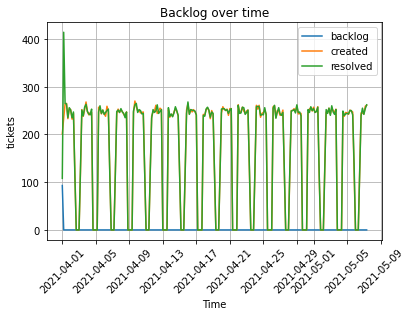

In [ ]:
t = df.loc[:, 'datetime']
b = df.loc[:, 'backlog']
c = df.loc[:, 'created']
r = df.loc[:, 'resolved']

fig, ax = plt.subplots()
line1, = ax.plot(t, b, label='backlog')
line2, = ax.plot(t, c, label='created')
line3, = ax.plot(t, r, label='resolved')

# format lines - dash of 

ax.set(xlabel='Time', ylabel='tickets', title='Backlog over time')
ax.grid()
ax.legend()
plt.xticks(rotation='45')
plt.show()